<a id='toc'></a>

##### Table of contents

* <a href="#te" style='color:#a52a2a'>Train & Eval Function</a>

* <a href="#bp" style='color:#a52a2a'>Mixed Naive Bayes Blueprint</a>

* <a href="#imp" style='color:#a52a2a'>Implementation - Bank Churn Data</a>

* <a href="#eval" style='color:#a52a2a'>Model Evaluation</a>

* <a href="#zf" style='color:#a52a2a'>Zero Frequency Problem</a>

* <a href="#tm" style='color:#a52a2a'>Threshold Moving</a>

* <a href="#impt" style='color:#a52a2a'>Implementation - Toy Data</a>

* <a href="#gc" style='color:#a52a2a'>Groupby vs Crosstab</a>

Check My [YT channel](https://www.youtube.com/@ammopy)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from scipy import stats
from dataclasses import dataclass

from ipywidgets import interact, FloatSlider
from IPython.display import display
from jupyterthemes import jtplot

jtplot.style(context='notebook', ticks=True, grid=False)

from show_input import hide_code

**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='te'></a>

In [2]:
# function to iterate model training

hide_code() # hide code cell

def train_eval(model, df, target, dist = False, kfcv = False):
    """
    Train & Evaluate a given Model
    """   
    
    m = model
    
    if kfcv:
        # cross validation scheme - stratified Kfold
        skf = StratifiedKFold(shuffle = True, random_state = 42)
        
        # result container
        recall = []
        
        fold = 1 # fold counter

        for idx_tr, idx_ts in skf.split(df.drop(target, axis = 1), df[target]): # 80/20 splits
            x_tr, x_ts = df.iloc[idx_tr].drop(target, axis = 1), df.iloc[idx_ts].drop(target, axis = 1) 
            y_tr, y_ts = df.iloc[idx_tr][target], df.iloc[idx_ts][target]
            
            if dist: # mixed_nb
                tr_df = pd.concat([x_tr, y_tr], axis = 1)
                m.fit(tr_df, target, dist)
            else:
                m.fit(x_tr, y_tr)
            
            # predict
            y_pred_tr =  m.predict(x_tr)
            y_pred_ts =  m.predict(x_ts)
            
            if df[target].nunique() > 2: # multiclass
                tr_rec, ts_rec = recall_score(y_tr, y_pred_tr, average = 'macro'), recall_score(y_ts, y_pred_ts, average = 'macro')
            else:
                tr_rec, ts_rec = recall_score(y_tr, y_pred_tr), recall_score(y_ts, y_pred_ts)
            
            print(f'Fold {fold}: Training - Recall: {tr_rec.round(3):5}    Testing - Recall: {ts_rec.round(3):5}', 
                  '-' * 5, 'Confusion Matrix', '-' * 15, confusion_matrix(y_ts, y_pred_ts),'-' * 60, sep = '\n')

            recall.append(ts_rec) # update
            fold += 1
            
        print(f'Avg Recall: {np.mean(recall).round(3)}', sep = '')

    else:
        
        # single validation set
        x_tr, x_ts, y_tr, y_ts = train_test_split(df.drop(target, axis = 1), df[target], stratify = df[target], 
                                                  test_size = .25, random_state = 42)
        
        if dist: # mixed_nb
            tr_df = pd.concat([x_tr, y_tr], axis = 1)
            m.fit(tr_df, target, dist)
        else:
            m.fit(x_tr, y_tr) # fit

        y_pred =  m.predict(x_ts) # predict

        # evaluate
        print('Classification Report', '-' * 20, classification_report(y_ts, y_pred, zero_division = 0), '-' * 40,  
              'Confusion Matrix', '-' * 15, confusion_matrix(y_ts, y_pred), sep = '\n')
    
    return m

**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='bp'></a>

In [3]:
# Containers of parameters

hide_code() # hide code cell

@dataclass
class params_gaussian:
    mu: float
    sigma: float
        
    def __repr__(self):
        '''Controls decimal points when printing an object of this dataclass'''
        return f"params_gaussian(mu={self.mu:.3f}, sigma={self.sigma:.3f})"
    
@dataclass
class params_binomial:
    n: int
    p: float
        
    def __repr__(self):
        return f"params_binomial(n={self.n:.3f}, p={self.p:.3f})"
    
@dataclass
class params_bernoulli:
    p: float
        
    def __repr__(self):
        return f"params_bernoulli(p={self.p:.3f})"
    
@dataclass
class params_uniform:
    a: int
    b: int
        
    def __repr__(self):
        return f"params_uniform(a={self.a:.3f}, b={self.b:.3f})"

In [4]:
# Mixed Naive Bayes Classifier

hide_code() # hide code cell

class mixed_nb:
    '''Naive Bayes classifier for categorical and numeric features'''
    
    def __init__(self, prior = None, alpha = 0):
        ''' 
            prior: dict of class prior
            alpha: Additive (Laplace) smoothing parameter, (x + alpha / n + alpha * k) where:
                   x: category/level count per class
                   n: total observations per class
                   k: total categories/levels per feature
        '''
        self.prior = prior
        self.alpha = alpha
        
    def fit(self, df, target, dist):

        assert len(dist) == len(df.columns.drop(target)), 'Probability Distribution & Number Of Features Mismatch' 
    
        self.class_label = sorted(df[target].unique()) # class labels
        self.n_class = len(self.class_label) # class count
        self.dist = dist # feature distribution
        
        # Dict that should contain the proportion of data belonging to each class
        if self.prior:
            prior_dict = self.prior
        else: # estimate prior from training dataset
            prior_dict = df[target].value_counts(normalize = True).sort_index().to_dict()

        # Container of estimated parameters for each class
        params_dict = {}

        for clss in self.class_label: # for each class
            
            temp_df = df[df[target] == clss]
            
            # Container of estimated parameters for each feature
            feat_dict = {}

            for col, d in self.dist.items(): # for each feature
                
                if d == 'n': # gaussian
                    assert pd.api.types.is_numeric_dtype(temp_df[col]), \
                    f'\'{col}\' Distribution \'{d}\' and it\'s Dtype \'{temp_df[col].dtype}\' Mismatch'
                    m, s = np.mean(temp_df[col]), np.std(temp_df[col]) # Maximum Likelihood Estimate
                    params = params_gaussian(mu = m, sigma = s)
                elif d == 'bi': # binomial
                    assert pd.api.types.is_numeric_dtype(temp_df[col]), \
                    f'\'{col}\' Distribution \'{d}\' and it\'s Dtype \'{temp_df[col].dtype}\' Mismatch'
                    n = 30
                    p = (temp_df[col] / n).mean() # Maximum Likelihood Estimate
                    params = params_binomial(n = n, p = p) 
                elif d == 'u': # continous uniform
                    assert pd.api.types.is_numeric_dtype(temp_df[col]), \
                    f'\'{col}\' Distribution \'{d}\' and it\'s Dtype \'{temp_df[col].dtype}\' Mismatch'
                    a, b = temp_df[col].min(), temp_df[col].max() # Maximum Likelihood Estimate
                    params = params_uniform(a = a, b = b)
                elif d == 'br': # discrete Bernoulli
                    assert pd.api.types.is_numeric_dtype(temp_df[col]), \
                    f'\'{col}\' Distribution \'{d}\' and it\'s Dtype \'{temp_df[col].dtype}\' Mismatch'
                    if self.alpha == 0: # Check for zero frequency
                        assert temp_df[col].mean() != 0, f'Zero frequency encountered for \'{col}\' feature in \'{clss}\' class, ' \
                        'please specify alpha or remove feature.'
                        p = temp_df[col].mean() # Maximum Likelihood Estimate
                        params = params_bernoulli(p = p)
                    if self.alpha > 0:
                        # +2 as feature has 2 levels either 0 or 1
                        p = (temp_df[col].sum() + self.alpha) / (len(temp_df) + (self.alpha * 2)) # P feature == 1
                        params = params_bernoulli(p = p)
                elif d == 'c': # Categorical/Multinoulli           
                    msng = [x for x in df[col].unique() if x not in temp_df[col].unique()] # lvl with zero frequency, if any.
                    if self.alpha == 0: # Check for zero frequency
                        assert len(msng) == 0, f'Zero frequency encountered for lvl(s) \'{msng}\' of \'{col}\' feature in ' \
                        f'{clss}\' class, please specify alpha or remove feature.'     
                        params = temp_df[col].value_counts(normalize = True).sort_index().to_dict() # Maximum Likelihood Estimate
                    if self.alpha > 0:
                        if len(msng) > 0: # account for lvl(s) with zero frequency
                            n_level = temp_df[col].nunique() + len(msng)    
                            params = dict(temp_df[col].value_counts().sort_index().add(self.alpha) / \
                                          (len(temp_df) + (self.alpha * n_level))) 
                            for lvl in msng:
                                params[lvl] = self.alpha / (len(temp_df) + (self.alpha * n_level))
                            params = dict(sorted(params.items())) # sorting final param dict
                        else:
                            n_level = temp_df[col].nunique()
                            params = dict(temp_df[col].value_counts().sort_index().add(self.alpha) / \
                                          (len(temp_df) + (self.alpha * n_level)))                             
                
                # Update feature params
                feat_dict[col] = params

            # Update class container with feature params
            params_dict[clss] = feat_dict
        
        self.prior_dict = prior_dict
        self.params_dict = params_dict
        
        return self 
    
    def predict(self, x_test):
    
        pred_array = np.zeros((len(x_test), self.n_class)) # array of predictions with shape (m: test samples , n: class label)
        
        n = 0 # counter to update prediction array for each class iteration, if class label is string.
        
        for clss in self.class_label: # for each class, start with 'No - 0 class label', order matters to update prediction array
               
            prob_ = 1 # initial probability
#             prob_ = 0 # initial probability for log implementation

            params = self.params_dict[clss] # fetch class params

            # P(X | C) for each value of x for a given feature with a specific distribution within each class 
            for feat, d in self.dist.items():
                
                if d == 'n': # gaussian
                    proba = stats.norm(params[feat].mu, params[feat].sigma).pdf(x_test[feat].values).reshape(-1,1)
                    prob_ *= proba # update initial probability              
                elif d == 'bi': # binomial
                    proba = stats.binom(params[feat].n, params[feat].p).pmf(x_test[feat].values).reshape(-1,1)
                    prob_ *= proba
                elif d == 'u': # continuous uniform
                    a = params[feat].a
                    b = params[feat].b
                    proba = x_test[feat].apply(lambda x: 1 / (b - a) if a <= x <= b else 1).values.reshape(-1,1) # else 1=skip if 0
                    prob_ *= proba
                elif d == 'br': # discrete Bernoulli 
                    proba = stats.bernoulli(params[feat].p).pmf(x_test[feat].values).reshape(-1,1)
                    prob_ *= proba
#                     proba = np.log(stats.bernoulli(params[feat].p).pmf(x_test[feat].values)).reshape(-1,1) # log implementation
#                     prob_ += proba   # <-- global prob_ = 0 not 1
                elif d == 'c': # categorical/Multinoulli
                    proba = x_test[feat].map(params[feat]).values.reshape(-1,1)
                    prob_ *= proba
                    
            pred = prob_* self.prior_dict[clss] # P(C & X)
#             pred = prob_+ np.log(self.prior_dict[clss]) # log P(C & X) - log implementation
            
            if type(clss) == str: # for string class label
                pred_array[:, n : n + 1] = pred
                n += 1
            else:
                pred_array[:, clss : clss + 1] = pred

        self.pred_array = pred_array # P(C & X)
        self.pred_proba = (pred_array / pred_array.sum(axis=1, keepdims=True)).round(3) # P(C | X): Class Probability
    
        return np.array([np.argmax(pred_array[_]) for _ in range(len(x_test))]) # P(C | X): Class Label

**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='imp'></a>

## The Data - Bank Churn

In [5]:
# Bank Churn DF

hide_code() # hide code cell

print('Bank Churn DataFrame')

churn_df = pd.read_csv('Churn_Modelling.csv')

display(churn_df.Exited.value_counts(normalize =True), churn_df.head())

Bank Churn DataFrame


0    0.7963
1    0.2037
Name: Exited, dtype: float64

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Feature Engineering

In [6]:
# Feature Engineering - Churn DF

hide_code() # hide code cell

print('Feature Engineering:', '  -Feature extraction - \'Loyalty\'' , 
      '  -Feature Transformation - Dummy encode \'Geography\'', sep = '\n')

# Feature extraction 
churn_df['Loyalty'] = churn_df.Tenure / churn_df.Age

# Feature Transformation - Dummy encode
churn_df = pd.concat([churn_df, pd.get_dummies(churn_df.Geography, drop_first= True)], axis = 1)

churn_df.iloc[:,2:]

Feature Engineering:
  -Feature extraction - 'Loyalty'
  -Feature Transformation - Dummy encode 'Geography'


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Germany,Spain
0,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.047619,0,0
1,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.025641,0,0
4,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0.046512,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0.128205,0,0
9996,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0.285714,0,0
9997,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,0.194444,0,0
9998,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,0.071429,1,0


## Feature Correlation

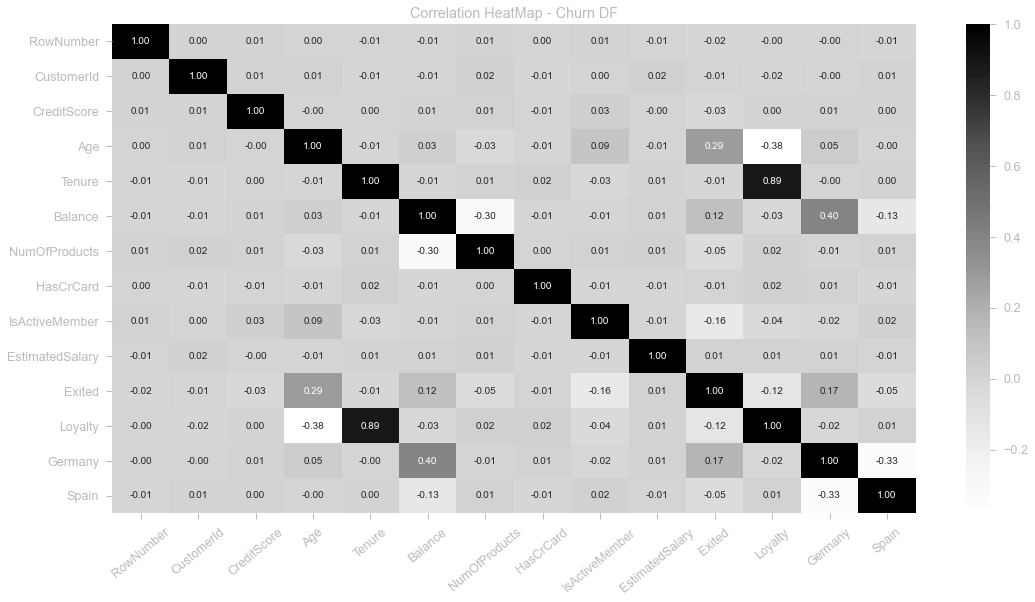

In [7]:
# Correlation - Churn DF

hide_code() # hide code cell

fig = plt.figure(figsize = (18,9))
corr_matrix = churn_df.corr()
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap = 'Greys')
plt.title("Correlation HeatMap - Churn DF")
plt.xticks(rotation = 40);

Naive Bayes models operate best when there's conditional independence between the features. We engineered `Loyalty` by dividing `Tenure` by `Age`. Thus, it's no longer conditionally independent. Therefore, we'll drop `Tenure` and `Age` to help adhere to the assumptions of our model.

If two random variables are correlated, they can't be statistically independent. But, if the correlation is 0, those variables can still be dependent. So, presence of correlation implies dependence; but the presence of dependence doesn't imply correlation.

## More Feature Engineering

In [8]:
# Feature selection - Drop unnecessary and redundant features

hide_code() # hide code cell

print('Feature Engineering:', '  -Feature selection - Drop unnecessary and redundant features', sep = '\n')

churn_df.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender', 'Tenure', 'Age', 'Geography'], axis = 1, inplace = True)

churn_df.head()

Feature Engineering:
  -Feature selection - Drop unnecessary and redundant features


,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Germany,Spain
0,619,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,125510.82,1,1,1,79084.10,0,0.046512,0,1


**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='eval'></a>

## Out-of-sample evaluation

In [9]:
# split data

hide_code() # hide code cell

X_train, X_test, = train_test_split(churn_df, stratify = churn_df.Exited, test_size = 0.25, random_state = 42)

print('Single train and test sets:', 
      f'  -Training data: {X_train.shape[0]:,} Samples and {X_train.shape[1]} Features',
      f'  -Testing data: {X_test.shape[0]:,} Samples and {X_test.shape[1]:,} Features', sep = '\n')

Single train and test sets:
  -Training data: 7,500 Samples and 10 Features
  -Testing data: 2,500 Samples and 10 Features


## Gaussian NB - Mixed

Mixed NB - Assuming Gaussian Features - Single Split
-------------------------------------------------------


'Estimated Priors'

{0: 0.7962666666666667, 1: 0.20373333333333332}

'Estimated Params'

{0: {'CreditScore': params_gaussian(mu=652.160, sigma=95.808),
  'Balance': params_gaussian(mu=72586.959, sigma=62875.610),
  'NumOfProducts': params_gaussian(mu=1.546, sigma=0.510),
  'HasCrCard': params_gaussian(mu=0.710, sigma=0.454),
  'IsActiveMember': params_gaussian(mu=0.555, sigma=0.497),
  'EstimatedSalary': params_gaussian(mu=98868.430, sigma=57085.021),
  'Loyalty': params_gaussian(mu=0.143, sigma=0.091),
  'Germany': params_gaussian(mu=0.210, sigma=0.408),
  'Spain': params_gaussian(mu=0.264, sigma=0.441)},
 1: {'CreditScore': params_gaussian(mu=644.052, sigma=99.523),
  'Balance': params_gaussian(mu=90950.368, sigma=58148.354),
  'NumOfProducts': params_gaussian(mu=1.477, sigma=0.801),
  'HasCrCard': params_gaussian(mu=0.696, sigma=0.460),
  'IsActiveMember': params_gaussian(mu=0.366, sigma=0.482),
  'EstimatedSalary': params_gaussian(mu=102167.067, sigma=58015.905),
  'Loyalty': params_gaussian(mu=0.119, sigma=0.077),
  'Germany': params_gaussian(mu=0.402, sigma=0.490),
 

Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1991
           1       0.54      0.30      0.39       509

    accuracy                           0.81      2500
   macro avg       0.69      0.62      0.64      2500
weighted avg       0.78      0.81      0.78      2500

----------------------------------------


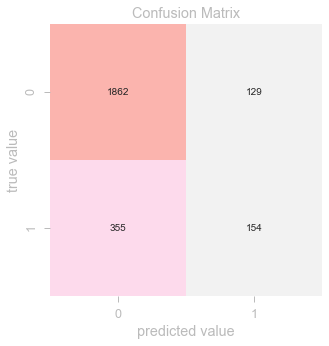

In [10]:
# Mixed NB - Churn DF - Gaussian

hide_code() # hide code cell

dist = dict(zip(X_train.drop('Exited', axis= 1), ['n' for _ in range(len(X_train.drop('Exited', axis= 1)))]))

m = mixed_nb().fit(X_train, 'Exited', dist)

y_pred = m.predict(X_test.drop('Exited', axis= 1))

y_test = X_test.Exited

print('Mixed NB - Assuming Gaussian Features - Single Split', '-' * 55, sep = '\n')

display('Estimated Priors', m.prior_dict, 'Estimated Params', m.params_dict)

print('Classification Report', '-' * 20, classification_report(y_test, y_pred), '-' * 40, sep = '\n')

fig = plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='g', cmap = 'Pastel1_r', cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title('Confusion Matrix');

## Making sense of numbers

#### Confusion Matrix


| Actual/Pred |        No         |        Yes      |
|-------------|-------------------|-----------------|
|  No         | 'True Negative'   | 'False Positive'|
|  Yes        | 'False Negative'  | 'True Positive' |


When comparing actual vs predicted results a single observation falls under one of the following 4 categories:

- True positive (TP): actual observation belongs to the positive class (1) and is correctly predicted as being positive (1).
- False positive (FP): actual observation belongs to the negative class (0) and is wrongly predicted as being positive (1).
- True negative (TN): actual observation belongs to the negative class (0) and is correctly predicted as being negative (0).
- False negative (FN): actual observation belongs to the positive class (1) and is wrongly predicted as being negative (0).

#### Accuracy: (tp + tn) / total samples = (154 + 1,862) / 2,500 = 81%

- Accuracy measures portion of correct predictions, existence of class imbalance reduce the credibility of this metrics because of large number of negative class.

#### Precision: tp / (tp + fp) = 154 / (154 + 129) = 54%

- 'how many positive predictions (pred = 1) are correct?'. It is a measure of how likely our predictions to be correct

#### Recall: tp / (tp + fn) = 154 / (154 + 355) = 30%
- 'Of all positive observations (churn = 1) how many did we predict correctly?'. It is a measure of the completeness of our predictions.

## Gaussian NB - Mixed - Cross Validation

In [11]:
# Kfold Cross Validation - Mixed NB - Churn DF - Gaussian

hide_code() # hide code cell

print('Mixed NB - Assuming Gaussian Features - Stratified Kfold Cross Validation', '-' * 70, sep = '\n')

m_kf = train_eval(mixed_nb(alpha = 1), churn_df, 'Exited', dist, kfcv = True)

Mixed NB - Assuming Gaussian Features - Stratified Kfold Cross Validation
----------------------------------------------------------------------
Fold 1: Training - Recall: 0.278    Testing - Recall: 0.287
-----
Confusion Matrix
---------------
[[1504   88]
 [ 291  117]]
------------------------------------------------------------
Fold 2: Training - Recall: 0.291    Testing - Recall: 0.257
-----
Confusion Matrix
---------------
[[1502   90]
 [ 303  105]]
------------------------------------------------------------
Fold 3: Training - Recall: 0.286    Testing - Recall: 0.297
-----
Confusion Matrix
---------------
[[1501   92]
 [ 286  121]]
------------------------------------------------------------
Fold 4: Training - Recall: 0.278    Testing - Recall:   0.3
-----
Confusion Matrix
---------------
[[1501   92]
 [ 285  122]]
------------------------------------------------------------
Fold 5: Training - Recall: 0.285    Testing - Recall: 0.278
-----
Confusion Matrix
---------------
[[1496  

## Gaussian NB - Sklearn

In [12]:
# Gaussian NB - sklearn - Churn DF

hide_code() # hide code cell

gnb = GaussianNB()
gnb.fit(X_train.drop('Exited', axis= 1), X_train.Exited)

# Get the predictions on test data
y_pred = gnb.predict(X_test.drop('Exited', axis= 1))

print('Classification Report', '-' * 20, 
      classification_report(y_test, y_pred, zero_division = 0), '-' * 40, 'Confusion Matrix', '-' * 15,
      confusion_matrix(y_test, y_pred), sep = '\n')

Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1991
           1       0.00      0.00      0.00       509

    accuracy                           0.80      2500
   macro avg       0.40      0.50      0.44      2500
weighted avg       0.63      0.80      0.71      2500

----------------------------------------
Confusion Matrix
---------------
[[1991    0]
 [ 509    0]]


What's happening? We are working blindly without studying the data, let's do some analysis.

## Summary statistics - Churn DF - Training Data

In [13]:
# summary statistics - Churn DF

hide_code() # hide code cell

X_train.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
CreditScore,7500.0,650.51,96.64,350.00,584.00,652.00,717.00,850.00
Balance,7500.0,76328.20,62385.96,0.00,0.00,96943.32,127785.45,222267.63
NumOfProducts,7500.0,1.53,0.58,1.00,1.00,1.00,2.00,4.00
HasCrCard,7500.0,0.71,0.46,0.00,0.00,1.00,1.00,1.00
IsActiveMember,7500.0,0.52,0.50,0.00,0.00,1.00,1.00,1.00
EstimatedSalary,7500.0,99540.47,57295.13,11.58,50417.95,98940.68,148428.57,199992.48
Exited,7500.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
Loyalty,7500.0,0.14,0.09,0.00,0.07,0.13,0.20,0.56
Germany,7500.0,0.25,0.43,0.00,0.00,0.00,0.00,1.00
Spain,7500.0,0.25,0.43,0.00,0.00,0.00,1.00,1.00


Scale of variables is wildly different. Example feature `EstimatedSalary` compared to `Loyalty`

## Distribution of numeric variables - Churn DF - Training Data

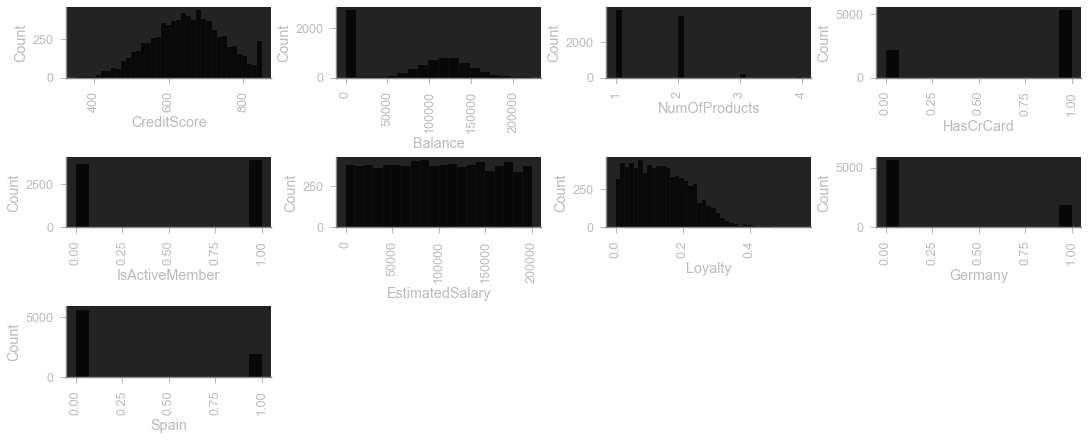

In [14]:
# visualize numeric variables - Churn DF

hide_code() # hide code cell

cols = X_train.drop('Exited', axis= 1).columns

fig = plt.figure(constrained_layout=True, figsize = (15,6))

for i, v  in enumerate(cols):
    fig.add_subplot(3, 4, i+1)
    sns.histplot(x = X_train[v], color = 'black')
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.xticks(rotation = 90);

Not All features are Gaussian.

## More Feature Engineering

In [15]:
# Feature Transformation - Scaling Data - Churn DF

hide_code() # hide code cell

print('Feature Transformation - Scaling Data - Churn DF - Training Data', '-' * 65, sep = '\n')

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_train.drop('Exited', axis= 1))

# Scale the training data
X_train_s = pd.DataFrame(scaler.transform(X_train.drop('Exited', axis= 1)), index = X_train.index,
                         columns = X_train.drop('Exited', axis= 1).columns)

# Scale the test data
X_test_s = pd.DataFrame(scaler.transform(X_test.drop('Exited', axis= 1)), index = X_test.index,
                        columns = X_test.drop('Exited', axis= 1).columns)



X_train_s.describe().T.round(2)

Feature Transformation - Scaling Data - Churn DF - Training Data
-----------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
CreditScore,7500.0,0.60,0.19,0.0,0.47,0.60,0.73,1.0
Balance,7500.0,0.34,0.28,0.0,0.00,0.44,0.57,1.0
NumOfProducts,7500.0,0.18,0.19,0.0,0.00,0.00,0.33,1.0
HasCrCard,7500.0,0.71,0.46,0.0,0.00,1.00,1.00,1.0
IsActiveMember,7500.0,0.52,0.50,0.0,0.00,1.00,1.00,1.0
EstimatedSalary,7500.0,0.50,0.29,0.0,0.25,0.49,0.74,1.0
Loyalty,7500.0,0.25,0.16,0.0,0.12,0.23,0.36,1.0
Germany,7500.0,0.25,0.43,0.0,0.00,0.00,0.00,1.0
Spain,7500.0,0.25,0.43,0.0,0.00,0.00,1.00,1.0


BTW, Naive Bayes doesn't require and is not affected by feature scaling, we already saw this in Our Implementation of Mixed NB model. The problem is that we are forcing non-gaussian features on a gaussian model, where some of the assumption and the way calculations and approximations were designed may be violated. Thus, requiring these extra steps. In a nutshell; Model implementation may differ form one package to another but final result should be the same.

## Gaussian NB - Sklearn - Scaled Data

In [16]:
# Gaussian NB - sklearn - Churn DF - scaled data

hide_code() # hide code cell

gnb = GaussianNB()
gnb.fit(X_train_s, X_train.Exited)

# Get the predictions on test data
y_pred = gnb.predict(X_test_s)

print(f'Class priors: {gnb.class_prior_}', '-' * 40, 
      f'Estimated Params:', '-' * 15, gnb.theta_, '-' * 40, 
      'Classification Report', '-' * 20, classification_report(y_test, y_pred), '-' * 40, 
      'Confusion Matrix', '-' * 15, confusion_matrix(y_test, y_pred), sep = '\n')

Class priors: [0.79626667 0.20373333]
----------------------------------------
Estimated Params:
---------------
[[0.60431916 0.32657458 0.18212771 0.71014735 0.55509042 0.49433146
  0.25673272 0.2103148  0.26389819]
 [0.5881034  0.40919304 0.15903141 0.69568063 0.36649215 0.51082622
  0.21469031 0.40248691 0.20549738]]
----------------------------------------
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1991
           1       0.54      0.30      0.39       509

    accuracy                           0.81      2500
   macro avg       0.69      0.62      0.64      2500
weighted avg       0.78      0.81      0.78      2500

----------------------------------------
Confusion Matrix
---------------
[[1862  129]
 [ 355  154]]


## Gaussian NB - Mixed - Scaled Data

In [17]:
# MixedNB - Gaussian - Churn DF - scaled data

hide_code() # hide code cell

tr_df = pd.concat([X_train_s, X_train.Exited], axis = 1)

m = mixed_nb().fit(tr_df, 'Exited', dist)

y_pred = m.predict(X_test_s)

y_test = X_test.Exited

print('Mixed NB - Assuming Gaussian Features - Scaled Data', '-' * 55, sep = '\n')

display('Estimated Priors', m.prior_dict, 'Estimated Params', m.params_dict)

print('Classification Report', '-' * 20, classification_report(y_test, y_pred), '-' * 40, 
      'Confusion Matrix', '-' * 15, confusion_matrix(y_test, y_pred),sep = '\n')

Mixed NB - Assuming Gaussian Features - Scaled Data
-------------------------------------------------------


'Estimated Priors'

{0: 0.7962666666666667, 1: 0.20373333333333332}

'Estimated Params'

{0: {'CreditScore': params_gaussian(mu=0.604, sigma=0.192),
  'Balance': params_gaussian(mu=0.327, sigma=0.283),
  'NumOfProducts': params_gaussian(mu=0.182, sigma=0.170),
  'HasCrCard': params_gaussian(mu=0.710, sigma=0.454),
  'IsActiveMember': params_gaussian(mu=0.555, sigma=0.497),
  'EstimatedSalary': params_gaussian(mu=0.494, sigma=0.285),
  'Loyalty': params_gaussian(mu=0.257, sigma=0.164),
  'Germany': params_gaussian(mu=0.210, sigma=0.408),
  'Spain': params_gaussian(mu=0.264, sigma=0.441)},
 1: {'CreditScore': params_gaussian(mu=0.588, sigma=0.199),
  'Balance': params_gaussian(mu=0.409, sigma=0.262),
  'NumOfProducts': params_gaussian(mu=0.159, sigma=0.267),
  'HasCrCard': params_gaussian(mu=0.696, sigma=0.460),
  'IsActiveMember': params_gaussian(mu=0.366, sigma=0.482),
  'EstimatedSalary': params_gaussian(mu=0.511, sigma=0.290),
  'Loyalty': params_gaussian(mu=0.215, sigma=0.139),
  'Germany': params_gaussian(mu=0.402, sigma=0.490),
  'Spain': params_gaussian(mu=0.205, sig

Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.88      1991
           1       0.54      0.30      0.39       509

    accuracy                           0.81      2500
   macro avg       0.69      0.62      0.64      2500
weighted avg       0.78      0.81      0.78      2500

----------------------------------------
Confusion Matrix
---------------
[[1862  129]
 [ 355  154]]


Same Results as our implementation.

**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='zf'></a>

## Mixed NB - Zero Frequency Problem

In [18]:
# MixedNB - Churn DF - Mixed

hide_code() # hide code cell

print('Mixed NB - Mixed Features - Zero Frequency Problem', '-' * 50, sep = '\n')

dist = dict(zip(X_train.drop('Exited', axis= 1), ['n', 'n', 'c', 'br', 'br', 'u', 'n', 'br', 'br']))

m = mixed_nb().fit(tr_df, 'Exited', dist)

Mixed NB - Mixed Features - Zero Frequency Problem
--------------------------------------------------


AssertionError: Zero frequency encountered for lvl(s) '[1.0]' of 'NumOfProducts' feature in 0' class, please specify alpha or remove feature.

## Mixed NB - Laplace smoothing

In [19]:
# MixedNB - Churn DF - Mixed - smoothed

hide_code() # hide code cell

m = mixed_nb(alpha = 1).fit(tr_df, 'Exited', dist)

y_pred = m.predict(X_test_s)

y_test = X_test.Exited

print('Mixed NB - Mixed Features - Smoothing Alpha = 1 - Scaled Data - Churn DF', '-' * 70, sep = '\n')

display('Estimated Priors', m.prior_dict, 'Estimated Params', m.params_dict)

print('Classification Report', '-' * 20, classification_report(y_test, y_pred), '-' * 40, 
      'Confusion Matrix', '-' * 15, confusion_matrix(y_test, y_pred),sep = '\n')

Mixed NB - Mixed Features - Smoothing Alpha = 1 - Scaled Data - Churn DF
----------------------------------------------------------------------


'Estimated Priors'

{0: 0.7962666666666667, 1: 0.20373333333333332}

'Estimated Params'

{0: {'CreditScore': params_gaussian(mu=0.604, sigma=0.192),
  'Balance': params_gaussian(mu=0.327, sigma=0.283),
  'NumOfProducts': {0.0: 0.45967202141900937,
   0.3333333333333333: 0.5338018741633199,
   0.6666666666666667: 0.006358768406961178,
   1.0: 0.00016733601070950468},
  'HasCrCard': params_bernoulli(p=0.710),
  'IsActiveMember': params_bernoulli(p=0.555),
  'EstimatedSalary': params_uniform(a=0.000, b=1.000),
  'Loyalty': params_gaussian(mu=0.257, sigma=0.164),
  'Germany': params_bernoulli(p=0.210),
  'Spain': params_bernoulli(p=0.264)},
 1: {'CreditScore': params_gaussian(mu=0.588, sigma=0.199),
  'Balance': params_gaussian(mu=0.409, sigma=0.262),
  'NumOfProducts': {0.0: 0.6886422976501305,
   0.3333333333333333: 0.17232375979112272,
   0.6666666666666667: 0.10966057441253264,
   1.0: 0.0293733681462141},
  'HasCrCard': params_bernoulli(p=0.695),
  'IsActiveMember': params_bernoulli(p=0.367),
  'EstimatedSalary': params_uniform(a=0.000, b=0.999),
  'Loyalty': params_gauss

Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1991
           1       0.70      0.32      0.44       509

    accuracy                           0.83      2500
   macro avg       0.77      0.64      0.67      2500
weighted avg       0.82      0.83      0.81      2500

----------------------------------------
Confusion Matrix
---------------
[[1921   70]
 [ 347  162]]


**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='tm'></a>

## Threshold Moving

In [20]:
# Threshold Moving - Churn DF - scaled data

hide_code() # hide code cell

# predition probability of positive class
pred_proba = m.pred_proba[:,1]

def thresh_move(thresh):
    
    # assigning new classification threshold
    y_pred = pred_proba > thresh
    
    print(classification_report(y_test, y_pred, zero_division = 0), '-' * 40, confusion_matrix(y_test, y_pred), sep = '\n')
    
    pass
   
interact(thresh_move,
         thresh = FloatSlider(min = 0.0, max = 1, value = .5, step = .1, description = 'Thresh'));

interactive(children=(FloatSlider(value=0.5, description='Thresh', max=1.0), Output()), _dom_classes=('widget-…

Default classification threshold is .5, which is not optimal for imbalanced classification problem. decreasing threshold results in higher recall as more instances are being classified as positive class however this comes at the expense of decreased precision; there will always be a trade-off between recall and precession.

**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='impt'></a>

## Game Day DataFrame

In [21]:
# Play DF - Mixed

hide_code() # hide code cell

play_df = pd.read_csv('mixdnb_df.csv')

play_df

,outlook,temp,humidity,wind,pressure,adv_days,tickets_sold,play
0,Sunny,Hot,High,0,33.487430,7.0,43,No
1,Sunny,Hot,High,1,34.594983,8.0,41,No
2,Overcast,Hot,High,0,33.436148,24.0,96,Yes
3,Rain,Mild,High,0,30.186767,18.0,64,Yes
4,Rain,Cool,Normal,0,29.132179,16.0,97,Yes
5,Rain,Cool,Normal,1,33.578395,7.0,26,No
6,Overcast,Cool,Normal,1,27.864687,14.0,79,Yes
7,Sunny,Mild,High,0,36.531480,12.0,41,No
8,Sunny,Cool,Normal,0,29.790530,18.0,57,Yes
9,Rain,Mild,Normal,0,29.897680,18.0,81,Yes


## Mixed NB - Game Day Data - laplace smoothing

In [22]:
# Mixed NB - Play DF

hide_code() # hide code cell

print('Mixed NB - Mixed Features - Smoothing Alpha = 1 - Play DF', '-' * 45, sep = '\n')

dist = dict(zip(play_df.columns[:-1], ['c', 'c', 'c', 'br', 'n', 'bi', 'u']))

m = mixed_nb(alpha = 1).fit(play_df, 'play', dist)

display('Estimated Priors', m.prior_dict, 'Estimated Params', m.params_dict)

Mixed NB - Mixed Features - Smoothing Alpha = 1 - Play DF
---------------------------------------------


'Estimated Priors'

{'No': 0.35714285714285715, 'Yes': 0.6428571428571429}

'Estimated Params'

{'No': {'outlook': {'Overcast': 0.125, 'Rain': 0.375, 'Sunny': 0.5},
  'temp': {'Cool': 0.25, 'Hot': 0.375, 'Mild': 0.375},
  'humidity': {'High': 0.7142857142857143, 'Normal': 0.2857142857142857},
  'wind': params_bernoulli(p=0.571),
  'pressure': params_gaussian(mu=34.216, sigma=1.281),
  'adv_days': params_binomial(n=30.000, p=0.267),
  'tickets_sold': params_uniform(a=26.000, b=43.000)},
 'Yes': {'outlook': {'Overcast': 0.4166666666666667,
   'Rain': 0.3333333333333333,
   'Sunny': 0.25},
  'temp': {'Cool': 0.3333333333333333,
   'Hot': 0.25,
   'Mild': 0.4166666666666667},
  'humidity': {'High': 0.36363636363636365, 'Normal': 0.6363636363636364},
  'wind': params_bernoulli(p=0.364),
  'pressure': params_gaussian(mu=29.395, sigma=1.683),
  'adv_days': params_binomial(n=30.000, p=0.563),
  'tickets_sold': params_uniform(a=57.000, b=97.000)}}

## MixedNB vs Sklearn - Play DF - Bernoulli

In [23]:
# MixedNB vs Sklearn - Play DF - Bernoulli

hide_code() # hide code cell

# bernoulli features
bern_df = play_df[['humidity', 'wind', 'play']].copy()
bern_df.humidity = bern_df.humidity.map({'High':1, 'Normal':0})
bern_df.play = bern_df.play.map({'Yes':1, 'No':0})

# MixedNB - Bernoulli
dist = dict(zip(bern_df.columns[:-1], ['br' for _ in range(len(bern_df.columns[:-1]))]))
m = mixed_nb(alpha = 1).fit(bern_df, 'play', dist)

# Sklearn - Bernoulli
bnb = BernoulliNB()
bnb.fit(bern_df.drop('play', axis = 1), bern_df.play)

# Comparison DF
params_df = pd.DataFrame(index = bern_df.columns[:-1])

params_df['mxd_0'] = [m.params_dict[0][_].p.round(3) for _ in bern_df.columns[:-1]]
params_df['skl_0'] = np.exp(bnb.feature_log_prob_[0]).round(3)
params_df['mxd_1'] = [m.params_dict[1][_].p.round(3) for _ in bern_df.columns[:-1]]
params_df['skl_1'] = np.exp(bnb.feature_log_prob_[1]).round(3)

display('Estimated Params', params_df.T)

'Estimated Params'

,humidity,wind
mxd_0,0.714,0.571
skl_0,0.714,0.571
mxd_1,0.364,0.364
skl_1,0.364,0.364


## MixedNB vs Sklearn - Play DF - Categorical

In [24]:
# MixedNB vs Sklearn - Play DF - Categorical

hide_code() # hide code cell

# categorical features only
cat_df = play_df[['outlook', 'temp', 'play']].copy()

# MixedNB - Categorical
dist = dict(zip(cat_df.columns[:-1], ['c' for _ in range(len(cat_df.columns[:-1]))]))
m = mixed_nb(alpha = 1).fit(cat_df, 'play', dist)

# Feature Encoding for Sklearn
cat_df_sk = cat_df.copy()

for col in cat_df_sk.columns:
    cat_df_sk[col] = LabelEncoder().fit_transform(cat_df_sk[col])

# Sklearn - Categorical
cnb = CategoricalNB()
cnb.fit(cat_df_sk.drop('play', axis = 1), cat_df_sk.play)

# Comparison DF
idx = np.r_[sorted(play_df.outlook.unique()), sorted(play_df.temp.unique())]
params_df = pd.DataFrame(index = idx)

cnb_params = cnb.feature_log_prob_

params_df['mxd_0'] = pd.json_normalize(m.params_dict['No'], sep = '_').values[0]
params_df['skl_0'] = np.exp(np.r_[cnb_params[0][0], cnb_params[1][0]])
params_df['mxd_1'] = pd.json_normalize(m.params_dict['Yes'], sep = '_').values[0]
params_df['skl_1'] = np.exp(np.r_[cnb_params[0][1], cnb_params[1][1]])

display('Estimated Params', params_df.T.round(3))

'Estimated Params'

,Overcast,Rain,Sunny,Cool,Hot,Mild
mxd_0,0.125,0.375,0.50,0.250,0.375,0.375
skl_0,0.125,0.375,0.50,0.250,0.375,0.375
mxd_1,0.417,0.333,0.25,0.333,0.250,0.417
skl_1,0.417,0.333,0.25,0.333,0.250,0.417


**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

<a id='gc'></a>

## Bays Rule Syntax - Single Event - Groupby vs Crosstab

In [25]:
# Syntax for Bays Rule

hide_code() # hide code cell

print('Bays Rule - Groupby vs Crosstab', '-' * 33, sep = '\n')

# P(class | event) -> normalize by 'index' OR groupby(event)[class]
# P(event | class) -> normalize by 'columns' OR groupby(class)[event]

display('P(C | E)', play_df.groupby('outlook').play.value_counts(normalize=True),
        pd.crosstab(play_df.outlook, play_df.play, normalize = 'index').round(2).T,
        'P(E | C)', play_df.groupby('play').outlook.value_counts(normalize=True),
        pd.crosstab(play_df.outlook, play_df.play, normalize = 'columns').round(2).T)        

Bays Rule - Groupby vs Crosstab
---------------------------------


'P(C | E)'

outlook   play
Overcast  Yes     1.0
Rain      Yes     0.6
          No      0.4
Sunny     No      0.6
          Yes     0.4
Name: play, dtype: float64

outlook,Overcast,Rain,Sunny
play,,,
No,0.0,0.4,0.6
Yes,1.0,0.6,0.4


'P(E | C)'

play  outlook 
No    Sunny       0.600000
      Rain        0.400000
Yes   Overcast    0.444444
      Rain        0.333333
      Sunny       0.222222
Name: outlook, dtype: float64

outlook,Overcast,Rain,Sunny
play,,,
No,0.00,0.40,0.60
Yes,0.44,0.33,0.22


In [26]:
pd.crosstab(play_df.outlook, play_df.play).round(2).T

outlook,Overcast,Rain,Sunny
play,,,
No,0,2,3
Yes,4,3,2


**<a href="#toc" style='color:#dc143c'>Table of contents</a>**

Check My [YT Channel](https://www.youtube.com/@ammopy)